In [1]:
from importlib import reload
import sys
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import pybedtools
from joblib import Parallel, delayed
import get_feature_matrix_perchr as gfm
from tqdm import tqdm
import time

In [2]:
# Reload modules in case of modifications
reload(gfm)

<module 'get_feature_matrix_perchr' from '/home/louiscam/projects/gpcr/code/epigenome_processing/get_feature_matrix_perchr.py'>

# Data directories

In [3]:
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'

In [4]:
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

In [ ]:
# List available genomic features and file names in a data frame
features = ['H3K4me1','H3K4me2','H3K4me3','H3K36me3',
            'H3K9ac','POLR2A','H3K9me3','H3K27me3',
            'RNAseq','ATACseq']
filenames = ['E017-H3K4me1.broadPeak',
             'E017-H3K4me2.broadPeak',
             'E017-H3K4me3.broadPeak',
             'E017-H3K36me3.broadPeak',
             'E017-H3K9ac.broadPeak',
             'wgEncodeAwgTfbsSydhImr90Pol2IggrabUniPk.narrowPeak',
             'E017-H3K9me3.broadPeak',
             'E017-H3K27me3.broadPeak',
             'GSM438363_UCSD.IMR90.mRNA-Seq.mRNA-seq_imr90_r1.bed',
             'ENCFF243NTP.bed']
sources = ['RoadmapEpigenomics','RoadmapEpigenomics','RoadmapEpigenomics',
           'RoadmapEpigenomics','RoadmapEpigenomics','ENCODE',
           'RoadmapEpigenomics','RoadmapEpigenomics','ENCODE',
           'ENCODE']
accessions = ['GSE16256','GSE16256','GSE16256','GSE16256','GSE16256',
              'GSE31477','GSE16256','GSE16256','ENCSR424FAZ','ENCSR200OML']
df = pd.DataFrame({'feature': features,'filename': filenames, 'source': sources, 'accession':accessions})
df.to_csv(epigenome_data_dir + 'features.csv')

# Process histone ChiP-seq data for one chromosome

- POLR2A: http://genome.ucsc.edu/cgi-bin/hgTracks?tsCurTab=advancedTab&tsGroup=Any&tsType=Any&hgt_mdbVar1=dccAccession&hgt_tSearch=search&hgt_tsDelRow=&hgt_tsAddRow=&hgt_tsPage=&tsSimple=&tsName=&tsDescr=&db=hg19&hgt_mdbVal1=wgEncodeEH002809
- H3K9me3: https://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/broadPeak/

In [100]:
# Get chromosome size
chrom = 1
sizes_filename = genome_dir+'chrom_hg19.sizes'
df_sizes = pd.read_csv(sizes_filename, sep = '\t', header = None, names=['chr','size'])
chrom_size = int(df_sizes.loc[df_sizes['chr']=='chr'+str(chrom)]['size'])
print(chrom_size)

249250621


In [101]:
# Divide the chromosome into segments of HIC_RESOLN length
stop_pos = np.arange(resol, chrom_size + resol, resol, dtype = 'int')
df_chrom = pd.DataFrame()
df_chrom['chrom'] = ['chr' + str(chrom)]*len(stop_pos)
df_chrom['start'] = stop_pos - resol
df_chrom['stop'] = stop_pos

In [102]:
# Convert to bed file
bed_chrom = pybedtools.BedTool.from_dataframe(df_chrom)
bed_chrom_df = bed_chrom.to_dataframe()

In [104]:
# Make a dataframe to store results into
df = pd.DataFrame({'feature': features, 
                   'filename': filenames})
feature_matrix = pd.DataFrame(index = df['feature'].values, columns = bed_chrom_df['start'].values)
for i in tqdm(range(len(df))):
    time.sleep(.01)
    f = df.loc[i, 'filename']
    feature = df.loc[i, 'feature']
    # Get bed file of the feature
    bed = pybedtools.BedTool(epigenome_dir + f).sort()
    # Get counts for this feature and this chromosome
    out = pybedtools.bedtool.BedTool.map(bed_chrom, bed, c = 4, o = 'count_distinct')
    counts = out.to_dataframe()['name'].values
    # Store results into matrix
    feature_matrix.loc[feature, :] = counts
# write feature matrix to file
feature_matrix.to_csv(processed_epigenome_data_dir + 'features_matrix_chr' + str(chrom) + '.csv')

100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


In [105]:
feature_matrix

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,247000000,247250000,247500000,247750000,248000000,248250000,248500000,248750000,249000000,249250000
H3K4me1,3,0,7,47,41,41,45,41,38,52,...,22,22,23,9,3,0,0,0,22,0
H3K4me2,0,0,3,28,20,24,30,36,38,19,...,8,14,18,5,5,1,0,0,16,0
H3K4me3,1,0,2,23,22,25,20,15,23,14,...,4,7,9,1,4,1,0,0,8,0
H3K36me3,3,0,22,48,38,30,46,41,40,31,...,54,28,16,1,10,1,0,1,13,0
H3K9ac,3,0,6,65,81,69,85,80,69,78,...,31,33,31,11,11,3,5,1,30,0
POLR2A,0,0,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,1,0
H3K9me3,4,0,5,31,33,19,18,61,33,36,...,44,54,58,77,73,86,71,51,26,0
H3K27me3,8,0,1,28,20,17,5,20,19,25,...,1,18,15,0,0,0,0,0,26,0


# Process histone ChiP-seq data for all chromosome

In [118]:
chr_list = np.arange(1,22+1)
for chrom in tqdm(chr_list):
    time.sleep(.01)
    
    # Get chromosome size
    sizes_filename = genome_dir+'chrom_hg19.sizes'
    df_sizes = pd.read_csv(sizes_filename, sep = '\t', header = None, names=['chr','size'])
    chrom_size = int(df_sizes.loc[df_sizes['chr']=='chr'+str(chrom)]['size'])
    
    # Divide the chromosome into segments of HIC_RESOLN length
    stop_pos = np.arange(resol, chrom_size + resol, resol, dtype = 'int')
    df_chrom = pd.DataFrame()
    df_chrom['chrom'] = ['chr' + str(chrom)]*len(stop_pos)
    df_chrom['start'] = stop_pos - resol
    df_chrom['stop'] = stop_pos
    
    # Convert to bed file
    bed_chrom = pybedtools.BedTool.from_dataframe(df_chrom)
    bed_chrom_df = bed_chrom.to_dataframe()
    
    # Make a dataframe to store results into
    df = pd.DataFrame({'feature': features, 
                       'filename': filenames})
    feature_matrix = pd.DataFrame(index = df['feature'].values, columns = bed_chrom_df['start'].values)
    for i in range(len(df)):
        f = df.loc[i, 'filename']
        feature = df.loc[i, 'feature']
        # Get bed file of the feature
        bed = pybedtools.BedTool(epigenome_dir + f).sort()
        # Get counts for this feature and this chromosome
        out = pybedtools.bedtool.BedTool.map(bed_chrom, bed, c = 4, o = 'count_distinct')
        counts = out.to_dataframe()['name'].values
        # Store results into matrix
        feature_matrix.loc[feature, :] = counts
        
    # write feature matrix to file
    feature_matrix.to_csv(processed_epigenome_data_dir + 'features_matrix_chr' + str(chrom) + '.csv')

100%|██████████| 22/22 [32:19<00:00, 88.17s/it]


# Normalize ChIP-seq data

In [119]:
# Compute mean and standard deviation across all the genome for each feature
blacklist = {chrom: set() for chrom in np.arange(1,22+1)}

In [120]:
# collect chipseq data across all chromosomes into one dataframe
df_all = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'.csv', index_col = 0)
    # get all blacklisted locations
    blacklist_chr = blacklist[chrom]
    # get a list of columns to keep
    allcols = set(map(int,df_chipseq.columns))
    cols2keep = allcols - blacklist_chr
    df_chipseq_filt = df_chipseq[list(map(str,cols2keep))]
    # Concatenate to data for previous chromosomes
    df_all = pd.concat([df_all, df_chipseq_filt],axis=1)

In [121]:
# Transform data
df_all = np.log(df_all + 1)

In [122]:
# find mean and standard dev
mean_features = np.mean(df_all, axis =1)
std_features = np.std(df_all, axis=1)

In [123]:
# Normalize ChIP-seq data
for chrom in tqdm(chr_list):
    time.sleep(.01)    
    # get chipseq data
    df_chipseq = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'.csv', index_col = 0)
    # transform
    df_chipseq = np.log(df_chipseq + 1)
    # normalize
    df_norm = (df_chipseq.T - mean_features)/std_features
    # transpose back
    df_norm = df_norm.T
    # save
    df_norm.to_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'norm.csv')

100%|██████████| 22/22 [00:00<00:00, 25.94it/s]


In [127]:
df_norm

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,49000000,49250000,49500000,49750000,50000000,50250000,50500000,50750000,51000000,51250000
H3K4me1,-1.685095,-1.685095,-1.685095,-1.685095,-1.685095,-1.685095,-1.685095,-1.685095,-1.685095,-1.685095,...,-1.685095,-1.226778,-1.685095,-1.685095,0.443262,0.754034,0.988216,0.786294,0.860666,-1.685095
H3K4me2,-1.655396,-1.655396,-1.655396,-1.655396,-1.655396,-1.655396,-1.655396,-1.655396,-1.655396,-1.655396,...,-1.655396,-1.112994,-1.655396,-1.655396,0.514212,0.798193,0.798193,0.923664,0.763408,-1.655396
H3K4me3,-1.389419,-1.389419,-1.389419,-1.389419,-1.389419,-1.389419,-1.389419,-1.389419,-1.389419,-1.389419,...,-1.389419,-0.628214,-1.389419,-1.389419,1.139249,1.584526,2.100678,1.721978,2.053939,-1.389419
H3K36me3,-1.653881,-1.653881,-1.653881,-1.653881,-1.653881,-1.653881,-1.653881,-1.653881,-1.653881,-1.653881,...,-0.081085,0.235184,-0.165395,-0.081085,0.374163,0.826929,0.891074,0.848955,1.070967,-1.653881
H3K9ac,-2.475365,-2.475365,-2.475365,-2.475365,-2.475365,-2.475365,-2.475365,-2.475365,-2.475365,-2.475365,...,-0.645567,-0.557825,-0.557825,-0.743654,0.676021,0.730949,1.086144,1.204543,0.906078,-2.475365
POLR2A,-0.865347,-0.865347,-0.865347,-0.865347,-0.865347,-0.865347,-0.865347,-0.865347,-0.865347,-0.865347,...,-0.865347,-0.865347,-0.865347,-0.865347,1.155606,1.155606,1.155606,1.155606,1.155606,-0.865347
H3K9me3,-3.301084,-3.301084,-3.301084,-3.301084,-3.301084,-3.301084,-3.301084,-3.301084,-3.301084,-3.301084,...,-0.609396,-0.341489,-0.559045,-0.609396,0.134222,0.243909,0.134222,-0.303473,0.360468,-3.301084
H3K27me3,-1.547482,-1.547482,-1.547482,-1.547482,-1.547482,-1.547482,-1.547482,-1.547482,-1.547482,-1.547482,...,-1.547482,-1.547482,-1.547482,-1.077664,0.660868,0.331789,0.711099,0.372881,0.881440,-1.547482
RNAseq,-1.710399,-1.710399,-1.710399,-1.710399,-1.710399,-1.710399,-1.710399,-1.710399,-1.710399,-1.710399,...,-0.463169,-0.357675,-1.202040,-1.053355,0.617851,1.139740,1.471084,1.336606,0.919753,-1.710399


# Determine active and inactive regions

In [128]:
# collect normalized chipseq data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'norm.csv', index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_norm],axis=1)

In [129]:
df_all_norm

,chr_1_loc_0,chr_1_loc_250000,chr_1_loc_500000,chr_1_loc_750000,chr_1_loc_1000000,chr_1_loc_1250000,chr_1_loc_1500000,chr_1_loc_1750000,chr_1_loc_2000000,chr_1_loc_2250000,...,chr_22_loc_49000000,chr_22_loc_49250000,chr_22_loc_49500000,chr_22_loc_49750000,chr_22_loc_50000000,chr_22_loc_50250000,chr_22_loc_50500000,chr_22_loc_50750000,chr_22_loc_51000000,chr_22_loc_51250000
H3K4me1,-0.768461,-1.685095,-0.310145,0.874587,0.786294,0.786294,0.846446,0.786294,0.737293,0.940107,...,-1.685095,-1.226778,-1.685095,-1.685095,0.443262,0.754034,0.988216,0.786294,0.860666,-1.685095
H3K4me2,-1.655396,-1.655396,-0.570592,0.979582,0.727006,0.863441,1.031770,1.170222,1.211416,0.688826,...,-1.655396,-1.112994,-1.655396,-1.655396,0.514212,0.798193,0.798193,0.923664,0.763408,-1.655396
H3K4me3,-0.628214,-1.389419,-0.182938,2.100678,2.053939,2.188580,1.954035,1.655401,2.100678,1.584526,...,-1.389419,-0.628214,-1.389419,-1.389419,1.139249,1.584526,2.100678,1.721978,2.053939,-1.389419
H3K36me3,-0.661557,-1.653881,0.590538,1.131924,0.968534,0.804203,1.102095,1.021582,1.004332,0.826929,...,-0.081085,0.235184,-0.165395,-0.081085,0.374163,0.826929,0.891074,0.848955,1.070967,-1.653881
H3K9ac,-1.320891,-2.475365,-0.854856,1.013683,1.194449,1.062684,1.234112,1.184231,1.062684,1.163410,...,-0.645567,-0.557825,-0.557825,-0.743654,0.676021,0.730949,1.086144,1.204543,0.906078,-2.475365
POLR2A,-0.865347,-0.865347,1.155606,1.155606,1.155606,1.155606,1.155606,1.155606,1.155606,1.155606,...,-0.865347,-0.865347,-0.865347,-0.865347,1.155606,1.155606,1.155606,1.155606,1.155606,-0.865347
H3K9me3,-1.802279,-3.301084,-1.632490,-0.073582,-0.017125,-0.511278,-0.559045,0.542352,-0.017125,0.061620,...,-0.609396,-0.341489,-0.559045,-0.609396,0.134222,0.243909,0.134222,-0.303473,0.360468,-3.301084
H3K27me3,-0.058195,-1.547482,-1.077664,0.734884,0.516107,0.411623,-0.333021,0.516107,0.483037,0.660868,...,-1.547482,-1.547482,-1.547482,-1.077664,0.660868,0.331789,0.711099,0.372881,0.881440,-1.547482
RNAseq,-0.417271,-0.996827,0.555833,1.589474,1.886255,1.783200,1.586608,1.082156,0.759634,1.056520,...,-0.463169,-0.357675,-1.202040,-1.053355,0.617851,1.139740,1.471084,1.336606,0.919753,-1.710399


In [17]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(df_all_norm.T)

In [18]:
np.sum(clustering.labels_==2)

5858

In [19]:
# Add cluster info to data
df_clusters = df_all_norm.T
df_clusters['cluster'] = clustering.labels_

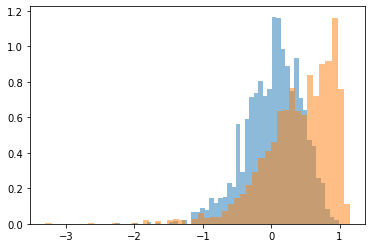

In [20]:
# Distribution of H3K9me3 in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['H3K9me3'],50, alpha=0.5, density=True)
plt.hist(df_clusters.loc[df_clusters['cluster']==2]['H3K9me3'],50, alpha=0.5, density=True)
plt.show()

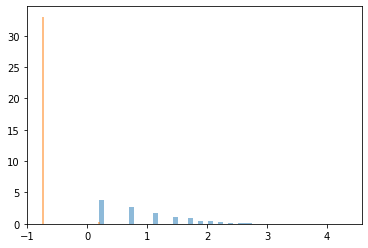

In [21]:
# Distribution of POLR2A in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['POLR2A'],50, alpha=0.5, density=True)
plt.hist(df_clusters.loc[df_clusters['cluster']==2]['POLR2A'],50, alpha=0.5, density=True)
plt.show()

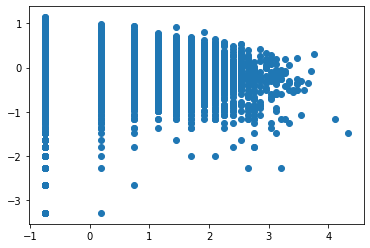

In [22]:
plt.scatter(df_clusters['POLR2A'],df_clusters['H3K9me3'])

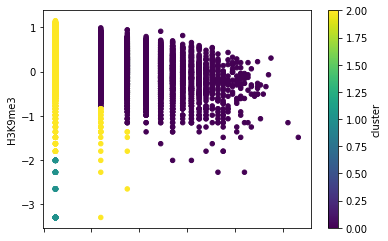

In [23]:
df_clusters.plot.scatter('POLR2A', 'H3K9me3', c='cluster', colormap='viridis')